# Naive Bayes Classification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from tqdm.notebook import tqdm

tqdm.pandas()


In [3]:
rootdir = "./data"

docs_df = pd.DataFrame()

for subdir, dirs, files in os.walk(rootdir):
    class_val = subdir.split("/")[-1]
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(subdir, file), "r") as f:
                data = f.read()
            docs_df.loc[file, ["text", "target"]] = [data, class_val]
docs_df = docs_df.reset_index(drop=True)


<Axes: ylabel='target'>

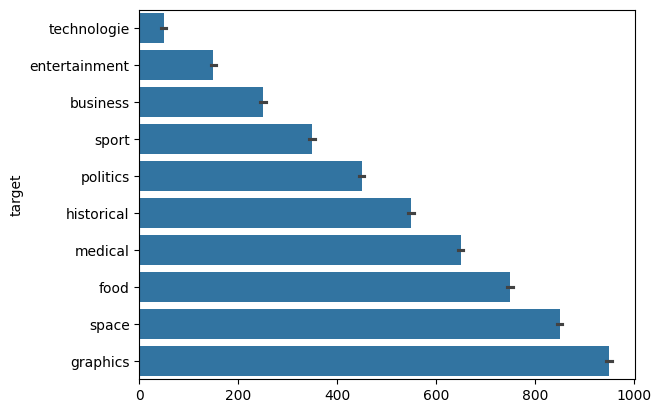

In [4]:
sns.barplot(docs_df["target"])

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    docs_df["text"], docs_df["target"], test_size=0.3, random_state=0
)

In [6]:
def text_clean(text, lemmatize=True, rm_stop=True):
    # Compile regex patterns once
    patterns = [
        (r"\n", ""),  # remove line breaks
        (r"\d+", ""),  # remove digits
        (r"[\$\d+\d+\$]", ""),  # remove currencies
        (r"\d+[\.\/-]\d+[\.\/-]\d+", ""),  # remove dates
        (r"[^\x00-\x7f]", " "),  # remove non-ascii
        (r"[^\w\s]", ""),  # remove punctuation
        (r"https?:\/\/.*[\r\n]*", ""),  # remove hyperlinks
    ]
    compiled_patterns = [(re.compile(pattern), repl) for pattern, repl in patterns]

    # Apply all regex substitutions
    text = text.lower()  # convert to lowercase
    for pattern, repl in compiled_patterns:
        text = pattern.sub(repl, text)

    # Tokenize once
    tokens = word_tokenize(text)

    # Remove stop words if requested
    if rm_stop:
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize if requested
    if lemmatize:
        lemmer = WordNetLemmatizer()
        tokens = [lemmer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

X_train_processed = X_train.apply(text_clean)
X_test_processed = X_test.apply(text_clean)

### Multinomial (Count of occurrences)

In [7]:
count_vec = CountVectorizer()
count_vectorized_data = count_vec.fit_transform(X_train_processed)

#define model
model = MultinomialNB(alpha=0.1)
model.fit(count_vectorized_data, Y_train)

#evaluate model
predictions = model.predict(count_vec.transform(X_test_processed))

accuracy = accuracy_score( Y_test, predictions)
balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions, average="macro")
recall = recall_score(Y_test, predictions, average="macro")


print("Accuracy:",round(100*accuracy,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')
print("Recall:", round(100*recall,2),'%')



Accuracy: 96.33 %
Balanced accuracy: 96.11 %
Precision: 96.49 %
Recall: 96.11 %


### Bernoulli (Does word exist in doc)

In [8]:
#define model
binary_vec = CountVectorizer(binary=True)
binary_vectorized_data = binary_vec.fit_transform(X_train_processed)


model_binary = BernoulliNB(alpha=0.1)
model_binary.fit(binary_vectorized_data, Y_train)

#evaluate model
predictions_binary = model_binary.predict(binary_vec.transform(X_test_processed))

accuracy = accuracy_score( Y_test, predictions_binary)
balanced_accuracy = balanced_accuracy_score(Y_test, predictions_binary)
precision = precision_score(Y_test, predictions_binary, average="macro")
recall = recall_score(Y_test, predictions_binary, average="macro")


print("Accuracy:",round(100*accuracy,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')
print("Recall:", round(100*recall,2),'%')


Accuracy: 88.67 %
Balanced accuracy: 88.01 %
Precision: 91.17 %
Recall: 88.01 %
